<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a leaf identification model with LIME
This notebook demonstrates the use of DIANNA with the LIME timeseries method on the coffee dataset.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the LIME parameters

#### 1. Imports and paths

In [1]:
import dianna
from pathlib import Path
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
#from dianna.methods import lime_timeseries
from lime import explanation
from lime import lime_base
import numpy as np
from fastdtw import fastdtw

#### 2. Loading the data

In [2]:
# Load coffee dataset
path_to_data = "data"
coffee_train = pd.read_csv(Path(path_to_data, "coffee_train.csv"),
                            sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv(Path(path_to_data, "coffee_test.csv"),
                           sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

In [4]:
# Define and train model
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
print('Accuracy KNN for coffee dataset: %f' % (acc(coffee_test_y, knn.predict(coffee_test_x))))

Accuracy KNN for coffee dataset: 0.964286


In [5]:
# Select instance for explanation
idx = 5 # explained instance
num_features = 50 # how many feature contained in explanation
series = coffee_test_x.iloc[idx, :]
num_slices = len(series) # split time series

class_names = ['Arabica', 'Robusta']
labels = np.argsort(class_names)
series.shape

(286,)

#### 3. Applying LIME with DIANNA

In [6]:
exp = dianna.explain_timeseries(knn.predict_proba, timeseries_data=series, method='lime',
                                labels=[0,1], class_names=class_names, num_features=num_features,
                                num_samples=5000, num_slices=num_slices, distance_method='cosine')

/home/yangliu/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 4. Plot results 

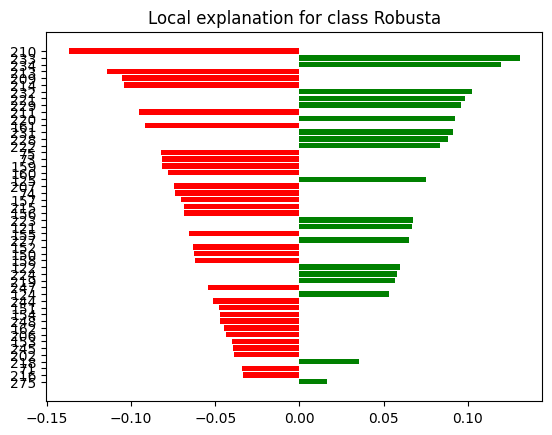

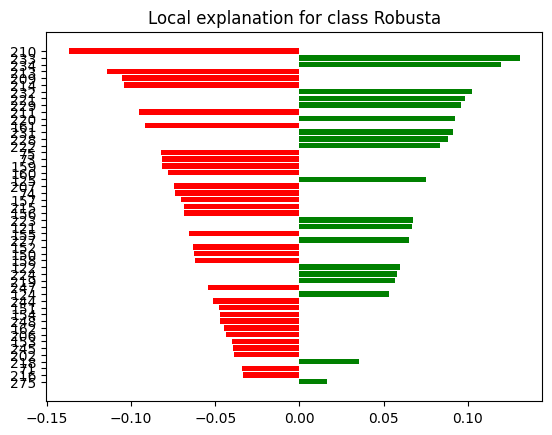

In [7]:
import matplotlib.pyplot as plt
exp.as_pyplot_figure()

1


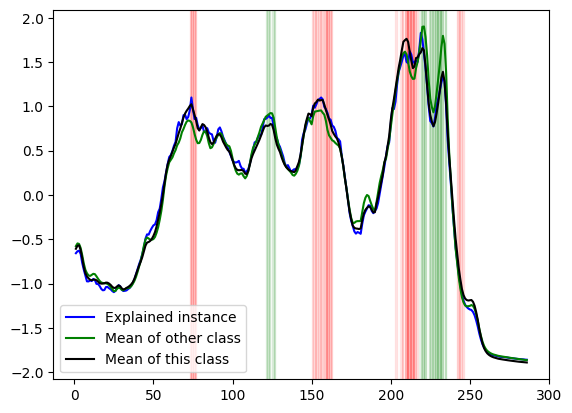

In [8]:
import math
values_per_slice = math.ceil(len(series) / num_slices)
print (values_per_slice)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.plot(coffee_test_x.iloc[:14,:].mean(), color='black', label='Mean of this class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

#### Functions to run lime for time-series - explicitly written here until lime_timeseries is finalised in DIANNA

In [9]:
#Mask data from dianna functions
from dianna.utils.maskers import generate_masks
from dianna.utils.maskers import mask_data
masks = generate_masks(series, 10, p_keep=0.9)
masked = mask_data(series, masks, mask_type='mean')

In [ ]:
#Domain Mapper for use in Lime
class TSDomainMapper(explanation.DomainMapper):
    def __init__(self, signal_names, num_slices, is_multivariate):
        """Init function.
        Args:
            signal_names: list of strings, names of signals
        """
        self.num_slices = num_slices
        self.signal_names = signal_names
        self.is_multivariate = is_multivariate
        
    def map_exp_ids(self, exp, **kwargs):
        # in case of univariate, don't change feature ids
        if not self.is_multivariate:
            return exp
        
        names = []
        for _id, weight in exp:
            # from feature idx, extract both the pair number of slice
            # and the signal perturbed
            nsignal = int(_id / self.num_slices)
            nslice = _id % self.num_slices
            signalname = self.signal_names[nsignal]
            featurename = "%d - %s" % (nslice, signalname)
            names.append((featurename, weight))
        return names

#Distance calculation
def distance_calc(input_data, masked_data):
        """Calculate distance based on dynamic time warping."""
        # implementation for reference
        # https://github.com/TortySivill/LIMESegment/blob/0a276e30f8d259642521407e7d51d07969169432/Utils/explanations.py#L111
        distance =  sklearn.metrics.pairwise.pairwise_distances(
                        masked, masked[0].reshape([1, -1]),
                        metric = 'cosine').ravel() * 100
        return distance

#### 3. Applying LIME with inbuilt functions

In [75]:
# Things we need to replace/reproduce
kernel_width = 25

distance = distance_calc(input_data=series, masked_data=masked)

verbose=False
explainer = lime_base.LimeBase(kernel, verbose)

predictions = knn.predict_proba(masked) 

domain_mapper = explanation.DomainMapper()
exp = explanation.Explanation(domain_mapper=domain_mapper, class_names=class_names)

for label in labels:
    (exp.intercept[int(label)],
                exp.local_exp[int(label)],
                exp.score,
                exp.local_pred) = explainer.explain_instance_with_data(masked,
                                                    predictions,
                                                    distance,
                                                    label=label,
                                                    num_features=num_features,
                                                    model_regressor = None,
    )

In [11]:
def dtw_distance(input_data, masked_data):
    """Calculate distance based on dynamic time warping."""
    # implementation for reference
    # https://github.com/TortySivill/LIMESegment/blob/0a276e30f8d259642521407e7d51d07969169432/Utils/explanations.py#L111
    distance =  np.asarray([fastdtw(input_data, one_masked_data)[0] for one_masked_data in masked_data])
    return distance

In [35]:
distance = dtw_distance(series, masked_data = masked)

In [36]:
distance

array([22.19070875, 25.71927442, 22.32230542, 23.18545725, 26.43324826,
       26.83284192, 29.09582042, 28.69291358, 22.12334709, 20.95898842])